## Density Estimation Using Real NVP - Simple Tutorial

From: https://github.com/xqding/RealNVP/blob/master/Real%20NVP%20Tutorial.ipynb

The basic idea behind Real NVP is to construct a bijective transformation/flow between latent variables and observed variables such that the transformation satisfies:

1. It is invertible and the determinant of its Jacobian matrix is easy to compute
2. It is flexible such that it can transform random variables of simple distributions into random variables of complex distributions

Other prominent implementations can be found here:

1. https://github.com/fmu2/realNVP/tree/master
2. https://github.com/kamenbliznashki/normalizing_flows

### Import Libraries

In [1]:
import numpy as np
import pickle
import math
from sys import exit
import matplotlib.pyplot as plt
from sklearn import datasets
import argparse

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as functional
import time
import os

torch.set_default_dtype(torch.float64) #use double precision numbers

### Implement Affine Coupling Layer Class

In [2]:
class Affine_Coupling(nn.Module):
    def __init__(self, mask, hidden_dim):
        super(Affine_Coupling, self).__init__()
        self.input_dim = len(mask)
        self.hidden_dim = hidden_dim

        ## mask to separate positions that do not change and positions that change.
        ## mask[i] = 1 means the ith position does not change.
        self.mask = nn.Parameter(mask, requires_grad = False)

        ## layers used to compute scale in affine transformation
        self.scale_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.scale_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.scale_fc3 = nn.Linear(self.hidden_dim, self.input_dim)
        self.scale = nn.Parameter(torch.Tensor(self.input_dim))
        init.normal_(self.scale)

        ## layers used to compute translation in affine transformation 
        self.translation_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.translation_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.translation_fc3 = nn.Linear(self.hidden_dim, self.input_dim)

    def _compute_scale(self, x):
        ## compute scaling factor using unchanged part of x with a neural network
        x = x*self.mask
        s = torch.relu(self.scale_fc1(x))
        s = torch.relu(self.scale_fc2(s))
        s = torch.relu(self.scale_fc3(s)) * self.scale        
        return s

    def _compute_translation(self, x):
        ## compute translation using unchanged part of x with a neural network 
        x = x*self.mask       
        t = torch.relu(self.translation_fc1(x*self.mask))
        t = torch.relu(self.translation_fc2(t))
        t = self.translation_fc3(t)        
        return t
    
    def forward(self, x):
        ## convert latent space variable to observed variable
        s = self._compute_scale(x)
        t = self._compute_translation(x)
        
        y = self.mask*x + (1-self.mask)*(x*torch.exp(s) + t)        
        logdet = torch.sum((1 - self.mask)*s, -1)
        
        return y, logdet

    def inverse(self, y):
        ## convert observed variable to latent space variable
        s = self._compute_scale(y)
        t = self._compute_translation(y)
                
        x = self.mask*y + (1-self.mask)*((y - t)*torch.exp(-s))
        logdet = torch.sum((1 - self.mask)*(-s), -1)
        
        return x, logdet

### Implement Real NVP by combining Affine Coupling Layers

In [3]:
class RealNVP_2D(nn.Module):
    '''
    A vanilla RealNVP class for modeling 2 dimensional distributions
    '''
    def __init__(self, masks, hidden_dim):
        '''
        initialized with a list of masks. each mask define an affine coupling layer
        '''
        super(RealNVP_2D, self).__init__()        
        self.hidden_dim = hidden_dim        
        self.masks = nn.ParameterList(
            [nn.Parameter(torch.Tensor(m),requires_grad = False)
             for m in masks])

        self.affine_couplings = nn.ModuleList(
            [Affine_Coupling(self.masks[i], self.hidden_dim)
             for i in range(len(self.masks))])
        
    def forward(self, x):
        ## convert latent space variables into observed variables
        y = x
        logdet_tot = 0
        for i in range(len(self.affine_couplings)):
            y, logdet = self.affine_couplings[i](y)
            logdet_tot = logdet_tot + logdet

        ## a normalization layer is added such that the observed variables is within
        ## the range of [-4, 4].
        logdet = torch.sum(torch.log(torch.abs(4*(1-(torch.tanh(y))**2))), -1)        
        y = 4*torch.tanh(y)
        logdet_tot = logdet_tot + logdet
        
        return y, logdet_tot

    def inverse(self, y):
        ## convert observed variables into latent space variables        
        x = y        
        logdet_tot = 0

        # inverse the normalization layer
        logdet = torch.sum(torch.log(torch.abs(1.0/4.0* 1/(1-(x/4)**2))), -1)
        x  = 0.5*torch.log((1+x/4)/(1-x/4))
        logdet_tot = logdet_tot + logdet

        ## inverse affine coupling layers
        for i in range(len(self.affine_couplings)-1, -1, -1):
            x, logdet = self.affine_couplings[i].inverse(x)
            logdet_tot = logdet_tot + logdet
            
        return x, logdet_tot

### Fully Connected Real NVP - Possible?

In [4]:
class Affine_Coupling_NJ(nn.Module):
    def __init__(self, mask, hidden_dim):
        super(Affine_Coupling_NJ, self).__init__()
        self.input_dim = len(mask)
        self.hidden_dim = hidden_dim

        ## mask to separate positions that do not change and positions that change.
        ## mask[i] = 1 means the ith position does not change.
        self.mask = nn.Parameter(mask, requires_grad = False)

        ## layers used to compute scale in affine transformation
        self.scale_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.scale_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.scale_fc3 = nn.Linear(self.hidden_dim, self.input_dim)
        self.scale = nn.Parameter(torch.Tensor(self.input_dim))
        init.normal_(self.scale)

        ## layers used to compute translation in affine transformation 
        self.translation_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.translation_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.translation_fc3 = nn.Linear(self.hidden_dim, self.input_dim)

    def _compute_scale(self, x):
        ## compute scaling factor using unchanged part of x with a neural network
        x = x*self.mask
        s = torch.relu(self.scale_fc1(x))
        s = torch.relu(self.scale_fc2(s))
        s = torch.relu(self.scale_fc3(s)) * self.scale        
        return s

    def _compute_translation(self, x):
        ## compute translation using unchanged part of x with a neural network 
        x = x*self.mask       
        t = torch.relu(self.translation_fc1(x*self.mask))
        t = torch.relu(self.translation_fc2(t))
        t = self.translation_fc3(t)        
        return t

    def _compute_forward_numerical_jacobian(self, y, x, s, t):
        ## compute the full jacobian numerically        
        batch = y.shape[0]
        nr = y.shape[1]
        nc = x.shape[1]
        J = torch.zeros(batch, nr, nc)
        
        #s = self._compute_scale(x)
        #t = self._compute_translation(x)
        
        sp = 0.05 # small perturbation

        for i in range(nc):
            if i == 0:

                #print(J.shape)
                #print(s.shape)
                J[:,0,0] = torch.exp(s[:,1])

                x_left, x_right = x.clone(), x.clone()
                x_left[:, 0], x_right[:, 0] = x_left[:, 0] - sp, x_right[:, 0] + sp                
                s_left, s_right = self._compute_scale(x_left), self._compute_scale(x_right)
                t_left, t_right = self._compute_translation(x_left), self._compute_translation(x_right) 
                
                dsdx1 = (s_right[:,0] - s[:,0])/sp
                dtdx1 = (t_right[:,0] - t[:,0])/sp
                J[:,1,0] = x[:,1]*torch.exp(s[:,0])*dsdx1 + dtdx1

            elif i == 1:

                x_left, x_right = x.clone(), x.clone()
                x_left[:, 1], x_right[:, 1] = x_left[:, 1] - sp, x_right[:, 1] + sp      
                s_left, s_right = self._compute_scale(x_left), self._compute_scale(x_right)
                t_left, t_right = self._compute_translation(x_left), self._compute_translation(x_right)
                
                dsdx2 = (s_right[:,1] - s[:,1])/sp
                dtdx2 = (t_right[:,1] - t[:,1])/sp
                J[:,0,1] = x[:,0]*torch.exp(s[:,1])*dsdx2 + dtdx2
                
                J[:,1,1] = torch.exp(s[:,0])
        
        return J

    def _compute_inverse_numerical_jacobian(self, x, y, s, t):
        ## compute the full jacobian numerically
        #print(x.shape)
        batch = x.shape[0]
        nr = x.shape[1]
        nc = y.shape[1]
        J = torch.zeros(batch, nr, nc)
        
        #s = self._compute_scale(y)
        #t = self._compute_translation(y)

        sp = 0.05 # small perturbation
        
        for i in range(nc):
            if i == 0:
                
                J[:,0,0] = torch.exp(-s[:,1])                

                y_left, y_right = y.clone(), y.clone()
                y_left[:, 0], y_right[:, 0] = y_left[:, 0] - sp, y_right[:, 0] + sp                
                s_left, s_right = self._compute_scale(y_left), self._compute_scale(y_right)
                t_left, t_right = self._compute_translation(y_left), self._compute_translation(y_right)  
                
                dsdy1 = (s_right[:,0] - s[:,0])/sp
                dtdy1 = (t_right[:,0] - t[:,0])/sp        
                
                J[:,1,0] = torch.exp(-s[:,0]) * (-dtdy1 + (t[:,0] - y[:,1])*dsdy1) 


                """
                print("y: ", y[:5,:])
                print("y_left: ", y_left[:5,:])
                print("y_right: ", y_right[:5,:])
                print()
                print("s: ", s[:5,:])
                print("s_left: ", s_left[:5,:])
                print("s_right: ", s_right[:5,:])
                print()
                print("dsdy1: ", dsdy1.max())
                print("dtdy1: ", dtdy1.max())
                print()
                """
                
                
            if i == 1:   

                y_left, y_right = y.clone(), y.clone()
                y_left[:, 1], y_right[:, 1] = y_left[:, 1] - sp, y_right[:, 1] + sp                
                s_left, s_right = self._compute_scale(y_left), self._compute_scale(y_right)
                t_left, t_right = self._compute_translation(y_left), self._compute_translation(y_right) 
                
                dsdy2 = (s_right[:,1] - s[:,1])/sp
                dtdy2 = (t_right[:,1] - t[:,1])/sp

                J[:,0,1] = torch.exp(-s[:,1]) * (-dtdy2 + (t[:,1] - y[:,0])*dsdy2)
        
                J[:,1,1] = torch.exp(-s[:,0]) 
        
        return J
    
    def forward(self, x):
        ## convert latent space variable to observed variable
        s = self._compute_scale(x)
        t = self._compute_translation(x)
        
        y = self.mask*x + (1-self.mask)*(x*torch.exp(s) + t)        
        logdet = torch.sum((1 - self.mask)*s, -1)

        # compute the jacobian numerically
        J = self._compute_forward_numerical_jacobian(y, x, s, t)
        logdet_NJ = torch.log(torch.abs(torch.linalg.det(J.to(device))))
        
        return y, logdet, logdet_NJ

    def inverse(self, y):
        ## convert observed variable to latent space variable
        s = self._compute_scale(y)
        t = self._compute_translation(y)
                
        x = self.mask*y + (1-self.mask)*((y - t)*torch.exp(-s))
        logdet = torch.sum((1 - self.mask)*(-s), -1)

         # compute the jacobian numerically
        J = self._compute_inverse_numerical_jacobian(x, y, s, t)
        logdet_NJ = torch.log(torch.abs(torch.linalg.det(J.to(device))))

        
        #print(J[:5,:,:])
        #print("J shape: ", J.shape)
        #print("logdet_NJ : ", logdet_NJ[:5])
        #print("logdet : ", logdet[:5])
        #print("\n\n")
        
        
        return x, logdet, logdet_NJ

In [5]:
class RealNVP_2D_NJ(nn.Module):
    '''
    A vanilla RealNVP class for modeling 2 dimensional distributions with full numerical Jacobian
    '''
    def __init__(self, masks, hidden_dim):
        '''
        initialized with a list of masks. each mask define an affine coupling layer
        '''
        super(RealNVP_2D_NJ, self).__init__()        
        self.hidden_dim = hidden_dim        
        self.masks = nn.ParameterList(
            [nn.Parameter(torch.Tensor(m),requires_grad = False)
             for m in masks])

        self.affine_couplings = nn.ModuleList(
            [Affine_Coupling_NJ(self.masks[i], self.hidden_dim)
             for i in range(len(self.masks))])
        
    def forward(self, x):
        ## convert latent space variables into observed variables
        y = x
        logdet_tot = 0
        logdet_tot_NJ = 0
        
        for i in range(len(self.affine_couplings)):
            y, logdet, logdet_NJ = self.affine_couplings[i](y)
            logdet_tot = logdet_tot + logdet
            logdet_tot_NJ = logdet_tot_NJ + logdet_NJ

        ## a normalization layer is added such that the observed variables is within
        ## the range of [-4, 4].
        logdet = torch.sum(torch.log(torch.abs(4*(1-(torch.tanh(y))**2))), -1)        
        y = 4*torch.tanh(y)
        logdet_tot = logdet_tot + logdet
        logdet_tot_NJ = logdet_tot_NJ + logdet  
        
        return y, logdet_tot, logdet_tot_NJ

    def inverse(self, y):
        ## convert observed variables into latent space variables        
        x = y        
        logdet_tot = 0 
        logdet_tot_NJ = 0

        # inverse the normalization layer
        logdet = torch.sum(torch.log(torch.abs(1.0/4.0* 1/(1-(x/4)**2))), -1)
        x  = 0.5*torch.log((1+x/4)/(1-x/4))
        logdet_tot = logdet_tot + logdet
        logdet_tot_NJ = logdet_tot_NJ + logdet

        ## inverse affine coupling layers
        for i in range(len(self.affine_couplings)-1, -1, -1):
            x, logdet, logdet_NJ = self.affine_couplings[i].inverse(x)
            logdet_tot = logdet_tot + logdet
            logdet_tot_NJ = logdet_tot_NJ + logdet_NJ
            
        return x, logdet_tot, logdet_tot_NJ

==> Architecture: 
None
RealNVP_2D_NJ(
  (masks): ParameterList(
      (0): Parameter containing: [torch.float64 of size 2]
      (1): Parameter containing: [torch.float64 of size 2]
      (2): Parameter containing: [torch.float64 of size 2]
      (3): Parameter containing: [torch.float64 of size 2]
      (4): Parameter containing: [torch.float64 of size 2]
      (5): Parameter containing: [torch.float64 of size 2]
      (6): Parameter containing: [torch.float64 of size 2]
      (7): Parameter containing: [torch.float64 of size 2]
  )
  (affine_couplings): ModuleList(
    (0-7): 8 x Affine_Coupling_NJ(
      (scale_fc1): Linear(in_features=2, out_features=128, bias=True)
      (scale_fc2): Linear(in_features=128, out_features=128, bias=True)
      (scale_fc3): Linear(in_features=128, out_features=2, bias=True)
      (translation_fc1): Linear(in_features=2, out_features=128, bias=True)
      (translation_fc2): Linear(in_features=128, out_features=128, bias=True)
      (translation_fc3):

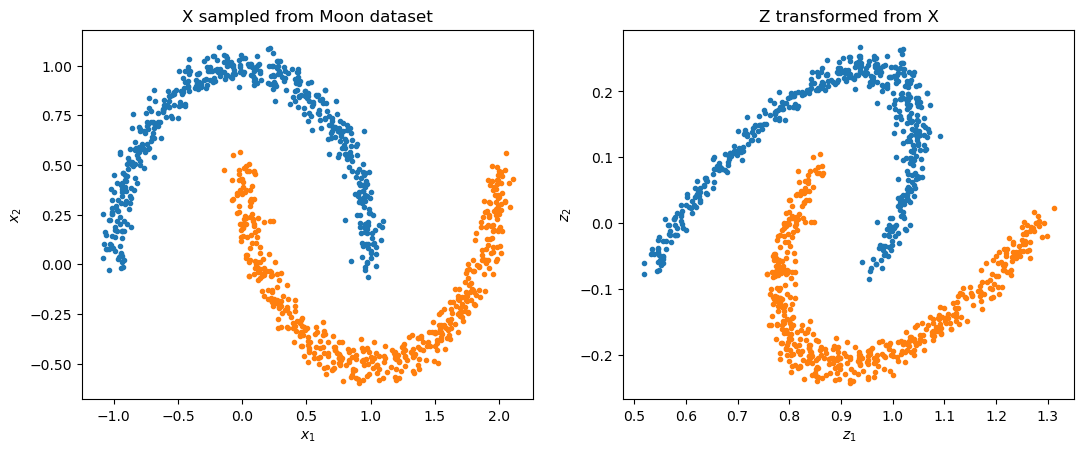

In [9]:
## Seed random generators
SEED = 3    
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Masks used to define the number and the type of affine coupling layers
## In each mask, 1 means that the variable at the corresponding position is
## kept fixed in the affine coupling layer
masks = [[1.0, 0.0],
         [0.0, 1.0],
         [1.0, 0.0],         
         [0.0, 1.0],
         [1.0, 0.0],         
         [0.0, 1.0],
         [1.0, 0.0],
         [0.0, 1.0]]

## dimension of hidden units used in scale and translation transformation
hidden_dim = 128

## construct the RealNVP_2D object
realNVP_type = "numerical" # analytical, numerical
if realNVP_type == "analytical":
    realNVP = RealNVP_2D(masks, hidden_dim)
elif realNVP_type == "numerical":
    realNVP = RealNVP_2D_NJ(masks, hidden_dim)

print(print("==> Architecture: "))
print(realNVP)
#exit()

if torch.cuda.device_count():
    realNVP = realNVP.cuda()
device = next(realNVP.parameters()).device

optimizer = optim.Adam(realNVP.parameters(), lr = 0.0001)

EPOCHS = 174
# num_steps = 5000


# save path for the results
experiment_number = 0
save_path = realNVP_type +"_"+str(experiment_number+1)
if not os.path.exists(save_path):
    os.makedirs(save_path)

## the following loop learns the RealNVP_2D model by data
## in each loop, data is dynamically sampled from the scipy moon dataset
print("==> Training:")
best_valid_loss = float('inf')
start = time.time()
for epoch in range(EPOCHS):
    ## sample data from the scipy moon dataset
    X, label = datasets.make_moons(n_samples = 512, noise = 0.05)
    X = torch.Tensor(X).to(device = device) 
    
    if realNVP_type == "analytical":
        ## transform data X to latent space Z
        z, logdet = realNVP.inverse(X)

        ## calculate the negative loglikelihood of X
        loss = torch.log(z.new_tensor([2*math.pi])) + torch.mean(torch.sum(0.5*z**2, -1) - logdet)
    
        print("loss: ", loss)
        print("\n")
        
    elif realNVP_type == "numerical":
        ## transform data X to latent space Z
        z, logdet, logdet_NJ = realNVP.inverse(X)
        
        ## calculate the negative loglikelihood of X
        loss = torch.log(z.new_tensor([2*math.pi])) + torch.mean(torch.sum(0.5*z**2, -1) - logdet_NJ)

        print("\n")
        print("loss: ", loss)
        

    #print(z.shape)
    #print(z.new_tensor([2*math.pi]))
    #print(logdet)
    #print(torch.sum(0.5*z**2, -1))

    
    
    #exit()
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    #if (epoch + 1) % 1000 == 0:
    #if (epoch + 1) % (EPOCHS/10) == 0:
    if (epoch + 1) % 1 == 0:
        print(f"Epoch: {epoch:}, loss: {loss.item():.5f}")
        torch.save(realNVP.state_dict(), save_path+'/epoch_'+str(epoch)+'.pth')

end = time.time()
print("Elapsed time: {} seconds".format(end-start))
        
## after learning, we can test if the model can transform
## the moon data distribution into the normal distribution
X, label = datasets.make_moons(n_samples = 1000, noise = 0.05)
X = torch.Tensor(X).to(device = device)
if realNVP_type == "analytical":
    z, logdet_jacobian = realNVP.inverse(X)
elif realNVP_type == "numerical":
    z, logdet_jacobian, logdet_jacobian_NJ = realNVP.inverse(X)
z = z.cpu().detach().numpy()

X = X.cpu().detach().numpy()
fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(X[label==0,0], X[label==0,1], ".")
plt.plot(X[label==1,0], X[label==1,1], ".")
plt.title("X sampled from Moon dataset")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.subplot(1,2,2)
plt.plot(z[label==0,0], z[label==0,1], ".")
plt.plot(z[label==1,0], z[label==1,1], ".")
plt.title("Z transformed from X")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.show()

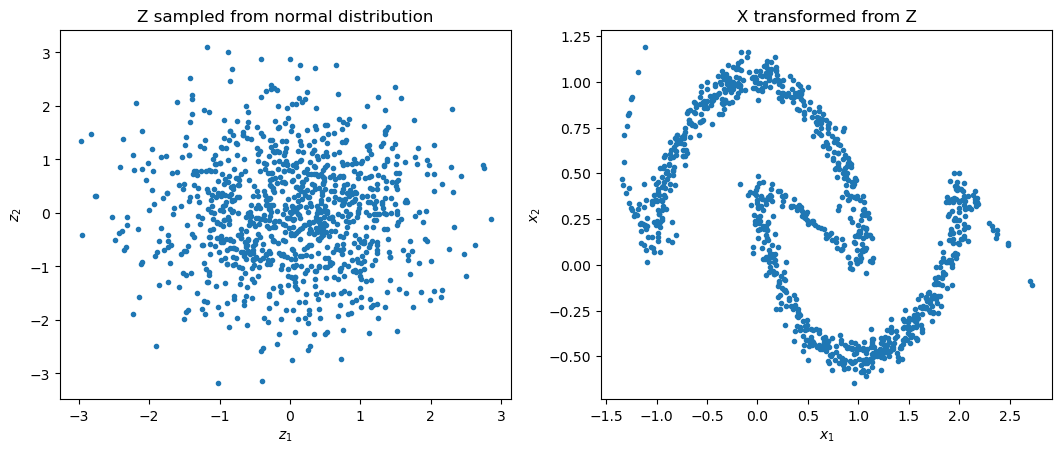

In [7]:
## after learning, we can also test if the model can transform
## the normal distribution into the moon data distribution 
if realNVP_type == "analytical":
    realNVP_test = RealNVP_2D(masks, hidden_dim).to(device)
elif realNVP_type == "numerical":
    realNVP_test = RealNVP_2D_NJ(masks, hidden_dim).to(device)
    
weights_file = save_path+"/epoch_4999.pth"

state_dict = realNVP_test.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)


z = torch.normal(0, 1, size = (1000, 2)).to(device = device)
if realNVP_type == "analytical":
    X, _ = realNVP_test(z)
elif realNVP_type == "numerical":
    X, _, _ = realNVP_test(z)
    
X = X.cpu().detach().numpy()
z = z.cpu().detach().numpy()

fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(z[:,0], z[:,1], ".")
plt.title("Z sampled from normal distribution")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")

plt.subplot(1,2,2)
plt.plot(X[:,0], X[:,1], ".")
plt.title("X transformed from Z")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.show()

In [8]:
# checking determinant computational cost
st = time.time()
J = torch.rand(256,256)
et = time.time()
print("{} seconds.".format(et-st))

st = time.time()
detJ = torch.linalg.det(J.to(device))
et = time.time()
print("{} seconds.".format(et-st))

0.0007562637329101562 seconds.
0.0838174819946289 seconds.
